In [1]:
%pip install librosa
%pip install fastdtw

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import librosa
import os
import json
from scipy import signal
from scipy.io import wavfile
from sklearn.mixture import GaussianMixture
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean
import matplotlib.pyplot as plt

np.random.seed(42)



#Load Speaker

In [3]:
def load_speaker_data(speaker_id: str, data_path: str) -> list:
    speaker_dir = os.path.join(data_path, speaker_id)
    audio_data = []

    # Check if directory exists
    if not os.path.exists(speaker_dir):
        print(f"Directory not found: {speaker_dir}")
        return []

    for file in os.listdir(speaker_dir):
        if file.endswith(".wav") or file.endswith(".flac"): 
            path = os.path.join(speaker_dir, file)
            audio, sr = librosa.load(path, sr=None)
            audio_data.append((audio, sr))

    return audio_data



preprocess_audio

In [4]:
def preprocess_audio(audio: np.ndarray, sr: int) -> tuple:
    if sr != 16000:
        audio = librosa.resample(audio, orig_sr=sr, target_sr=16000)
        sr = 16000

    if np.max(np.abs(audio)) > 0:
        audio = audio / np.max(np.abs(audio))

    audio = np.append(audio[0], audio[1:] - 0.97 * audio[:-1])

    audio, _ = librosa.effects.trim(audio, top_db=20)

    return audio, sr


compute_f0_stats

In [5]:
def compute_f0_stats(audio: np.ndarray, sr: int) -> dict:
    f0, _, _ = librosa.pyin(audio, fmin=50, fmax=500, sr=sr)
    f0 = f0[~np.isnan(f0)]

    return {
        "mean_f0": float(np.mean(f0)),
        "std_f0": float(np.std(f0)),
        "min_f0": float(np.min(f0)),
        "max_f0": float(np.max(f0))
    }


compute_rms_energy

In [6]:
def compute_rms_energy(audio: np.ndarray) -> float:
    return float(np.sqrt(np.mean(audio ** 2)))


PART B – FEATURE EXTRACTION

extract_f0

In [7]:
def extract_f0(audio: np.ndarray, sr: int) -> np.ndarray:
    f0, _, _ = librosa.pyin(audio, fmin=50, fmax=500, sr=sr)
    return np.nan_to_num(f0)


extract_mfcc

In [8]:
def extract_mfcc(audio: np.ndarray, sr: int, n_mfcc: int = 13) -> np.ndarray:
    mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc)
    return mfcc


extract_formants (LPC-based)

In [9]:
def extract_formants(audio: np.ndarray, sr: int) -> np.ndarray:
    audio = audio[:int(0.03 * sr)]  # 30 ms frame
    A = librosa.lpc(audio, order=12)
    roots = np.roots(A)
    roots = [r for r in roots if np.imag(r) >= 0]

    angles = np.angle(roots)
    freqs = angles * (sr / (2 * np.pi))
    freqs = np.sort(freqs)

    formants = freqs[:3] if len(freqs) >= 3 else [0, 0, 0]
    return np.array(formants)


calculate_pitch_shift_ratio

In [10]:
def calculate_pitch_shift_ratio(source_f0: np.ndarray, target_f0: np.ndarray) -> float:
    source_mean = np.mean(source_f0[source_f0 > 0])
    target_mean = np.mean(target_f0[target_f0 > 0])

    ratio = target_mean / source_mean
    return float(np.clip(ratio, 0.5, 2.0))


align_features_dtw

In [11]:
def align_features_dtw(source_features: np.ndarray, target_features: np.ndarray) -> np.ndarray:
    _, path = fastdtw(source_features.T, target_features.T, dist=euclidean)
    return np.array(path)


train_feature_mapping (GMM)

In [12]:
def train_feature_mapping(source_features: np.ndarray, target_features: np.ndarray):
    # Align features using DTW
    print("Aligning features...")
    path = align_features_dtw(source_features, target_features)
    
    X = source_features[:, path[:, 0]]
    Y = target_features[:, path[:, 1]]
    
    # Transpose for GMM (n_samples, n_features)
    X = X.T
    Y = Y.T
    
    print(f"Training GMM with {X.shape[0]} aligned frames...")
    gmm = GaussianMixture(n_components=8, covariance_type='diag', random_state=42)
    gmm.fit(np.hstack([X, Y]))

    return gmm


convert_features

In [13]:
def convert_features(model, source_features: np.ndarray) -> np.ndarray:
    n_components = model.n_components
    n_features = source_features.shape[0]  # Should be 13
    
    # Split means into source (X) and target (Y) parts
    # The GMM was trained on [X, Y], so first half is X, second is Y
    means_x = model.means_[:, :n_features]
    means_y = model.means_[:, n_features:]
    
    # We also need covariances. 
    # If covariance_type is 'diag', covariances_ is (n_components, n_features)
    # So we split it similarly.
    covs_x = model.covariances_[:, :n_features]
    covs_y = model.covariances_[:, n_features:]
    
    X = source_features.T
    converted = []

    for x_sample in X:
        # Let's simplify: Find the component k whose Source-Mean is closest to x_sample
        # This is a "Hard Clustering" approximation for conversion.
        dists = np.sum((means_x - x_sample)**2, axis=1)
        best_k = np.argmin(dists)
        
        # Mapping: y = mu_y_k + (sigma_yx_k * sigma_xx_k^-1) * (x - mu_x_k)
        # For 'diag' covariance, the cross-term sigma_yx is 0, so it simplifies to:
        # y = mu_y_k + (cov_y / cov_x)^0.5 * (x - mu_x_k) 
        # But commonly in simple GMM VC, we just take the mean: y ~ mu_y_k
        
        converted.append(means_y[best_k])
        
    return np.array(converted).T


PART C – VOICE CONVERSION

shift_pitch

In [14]:
def shift_pitch(audio: np.ndarray, sr: int, pitch_ratio: float) -> np.ndarray:
    n_steps = 12 * np.log2(pitch_ratio)
    shifted = librosa.effects.pitch_shift(y=audio, sr=sr, n_steps=n_steps)
    return shifted

convert_spectral_envelope

In [15]:
def convert_spectral_envelope(audio: np.ndarray, sr: int, mapping_model) -> np.ndarray:
    mfcc = extract_mfcc(audio, sr)
    converted_mfcc = convert_features(mapping_model, mfcc)

    spectrogram = librosa.feature.inverse.mfcc_to_mel(converted_mfcc)
    return spectrogram


voice_conversion_pipeline

In [16]:
def voice_conversion_pipeline(source_audio: np.ndarray, sr: int, mapping_model, pitch_ratio: float) -> np.ndarray:
    pitched = shift_pitch(source_audio, sr, pitch_ratio)
    spectrogram = convert_spectral_envelope(pitched, sr, mapping_model)
    audio = librosa.feature.inverse.mel_to_audio(spectrogram, sr=sr)
    return audio


PART D – EVALUATION

calculate_mcd

In [17]:
def calculate_mcd(converted_mfcc: np.ndarray, target_mfcc: np.ndarray) -> float:
    min_len = min(converted_mfcc.shape[1], target_mfcc.shape[1])
    diff = converted_mfcc[:, :min_len] - target_mfcc[:, :min_len]
    mcd = (10 / np.log(10)) * np.mean(np.sqrt(2 * np.sum(diff ** 2, axis=0)))
    return float(mcd)


calculate_f0_correlation

In [18]:
def calculate_f0_correlation(converted_f0: np.ndarray, target_f0: np.ndarray) -> float:
    # Truncate to min length
    min_len = min(len(converted_f0), len(target_f0))
    converted_f0 = converted_f0[:min_len]
    target_f0 = target_f0[:min_len]
    
    mask = (converted_f0 > 0) & (target_f0 > 0)
    if np.sum(mask) == 0:
        return 0.0
    return float(np.corrcoef(converted_f0[mask], target_f0[mask])[0, 1])

calculate_formant_rmse

In [19]:
def calculate_formant_rmse(converted_formants: np.ndarray, target_formants: np.ndarray) -> float:
    # Check if we have 1D arrays (single frame)
    if converted_formants.ndim == 1 and target_formants.ndim == 1:
        return float(np.sqrt(np.mean((converted_formants - target_formants) ** 2)))
        
    # If 2D (sequence of frames), use the previous logic
    min_len = min(converted_formants.shape[1], target_formants.shape[1])
    c_f = converted_formants[:, :min_len]
    t_f = target_formants[:, :min_len]
    
    return float(np.sqrt(np.mean((c_f - t_f) ** 2)))

Define Paths & Speakers

In [20]:
DATA_PATH = "content/wav48"   
SOURCE_SPEAKER = "p226"   # male
TARGET_SPEAKER = "p225"   # female


Load & Preprocess Data

In [21]:
source_data = load_speaker_data(SOURCE_SPEAKER, DATA_PATH)
target_data = load_speaker_data(TARGET_SPEAKER, DATA_PATH)

def preprocess_dataset(dataset):
    processed = []
    for audio, sr in dataset:
        audio, sr = preprocess_audio(audio, sr)
        processed.append(audio)
    return processed

source_audio = preprocess_dataset(source_data)
target_audio = preprocess_dataset(target_data)


c:\Users\sahaj\anaconda3\Lib\site-packages\paramiko\pkey.py:82: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "cipher": algorithms.TripleDES,
c:\Users\sahaj\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.Blowfish and will be removed from this module in 45.0.0.
  "class": algorithms.Blowfish,
c:\Users\sahaj\anaconda3\Lib\site-packages\paramiko\transport.py:243: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "class": algorithms.TripleDES,


In [22]:
# Dataset statistics
def dataset_stats(data):
    durations = [len(a)/sr for a, sr in data]
    srs = list(set([sr for _, sr in data]))
    return {
        "num_files": len(data),
        "sample_rates": srs,
        "min_duration": np.min(durations),
        "max_duration": np.max(durations),
        "mean_duration": np.mean(durations)
    }

print("Source speaker stats:", dataset_stats(source_data))
print("Target speaker stats:", dataset_stats(target_data))


Source speaker stats: {'num_files': 712, 'sample_rates': [48000], 'min_duration': 1.8415208333333333, 'max_duration': 12.152979166666666, 'mean_duration': 3.735750526685393}
Target speaker stats: {'num_files': 462, 'sample_rates': [48000], 'min_duration': 1.6227916666666666, 'max_duration': 12.154520833333333, 'mean_duration': 3.5591247294372295}


Train / Test Split (40–10)

In [23]:
source_train = source_audio[:40]
source_test  = source_audio[40:50]

target_train = target_audio[:40]
target_test  = target_audio[40:50]


Feature Extraction (TRAIN SET)

In [24]:
source_mfcc = []
target_mfcc = []

for s, t in zip(source_train, target_train):
    source_mfcc.append(extract_mfcc(s, 16000))
    target_mfcc.append(extract_mfcc(t, 16000))

source_mfcc = np.hstack(source_mfcc)
target_mfcc = np.hstack(target_mfcc)


In [25]:
# DTW alignment demonstration
dtw_path = align_features_dtw(
    source_mfcc[:, :300],
    target_mfcc[:, :300]
)

print("DTW alignment path length:", len(dtw_path))


DTW alignment path length: 332


Train Feature Mapping Model

In [26]:
mapping_model = train_feature_mapping(source_mfcc, target_mfcc)


Aligning features...
Training GMM with 6208 aligned frames...


Compute Pitch Shift Ratio

In [27]:
source_f0_all = []
target_f0_all = []

for s, t in zip(source_train, target_train):
    source_f0_all.append(extract_f0(s, 16000))
    target_f0_all.append(extract_f0(t, 16000))

source_f0_all = np.concatenate(source_f0_all)
target_f0_all = np.concatenate(target_f0_all)

pitch_ratio = calculate_pitch_shift_ratio(source_f0_all, target_f0_all)
pitch_ratio


1.6253909031566622

In [28]:
# Pitch statistics (mean, median, range)
def f0_summary(f0):
    f0 = f0[f0 > 0]
    return {
        "mean": np.mean(f0),
        "median": np.median(f0),
        "range": np.max(f0) - np.min(f0)
    }

print("Source F0 stats:", f0_summary(source_f0_all))
print("Target F0 stats:", f0_summary(target_f0_all))

Source F0 stats: {'mean': 116.2180405379004, 'median': 110.95694720678449, 'range': 397.8161247239103}
Target F0 stats: {'mean': 188.8997458729955, 'median': 179.21192838239048, 'range': 387.72835305590377}


Convert 3 Test Samples + Save WAVs

In [29]:
converted_audios = []

for i in range(3):
    converted = voice_conversion_pipeline(
        source_test[i],
        16000,
        mapping_model,
        pitch_ratio
    )
    converted_audios.append(converted)

    wavfile.write(
        f"converted_sample_{i+1}.wav",
        16000,
        (converted * 32767).astype(np.int16)
    )


Evaluation Metrics (TEST SET)

In [30]:
mcd_list = []
f0_corr_list = []
formant_rmse_list = []

for s, t in zip(source_test, target_test):
    converted = voice_conversion_pipeline(s, 16000, mapping_model, pitch_ratio)

    conv_mfcc = extract_mfcc(converted, 16000)
    tgt_mfcc  = extract_mfcc(t, 16000)
    mcd_list.append(calculate_mcd(conv_mfcc, tgt_mfcc))

    conv_f0 = extract_f0(converted, 16000)
    tgt_f0  = extract_f0(t, 16000)
    f0_corr_list.append(calculate_f0_correlation(conv_f0, tgt_f0))

    conv_form = extract_formants(converted, 16000)
    tgt_form  = extract_formants(t, 16000)
    formant_rmse_list.append(calculate_formant_rmse(conv_form, tgt_form))


Create evaluation_results.json

In [31]:
results = {
    "mcd": {
        "mean": float(np.mean(mcd_list)),
        "std": float(np.std(mcd_list)),
        "samples": mcd_list
    },
    "f0_correlation": {
        "mean": float(np.mean(f0_corr_list)),
        "std": float(np.std(f0_corr_list)),
        "samples": f0_corr_list
    },
    "formant_rmse": {
        # CHANGE HERE: Use the single average RMSE directly
        "average": float(np.mean(formant_rmse_list)),
        "samples": formant_rmse_list # Optional: save individual sample scores
    },
    "pitch_shift_ratio": float(pitch_ratio),
    "conversion_summary": {
        "source_speaker": SOURCE_SPEAKER,
        "target_speaker": TARGET_SPEAKER,
        "num_test_samples": 10,  # Or whatever variable you used
        "mapping_model_type": "GMM"
    }
}

with open("evaluation_results.json", "w") as f:
    json.dump(results, f, indent=4)
    
print("Evaluation results saved to evaluation_results.json")

Evaluation results saved to evaluation_results.json


PART E: REPORT – ANALYSIS & INSIGHTS

E.1 VISUALIZATIONS (CODE CELLS)


Waveform Comparison

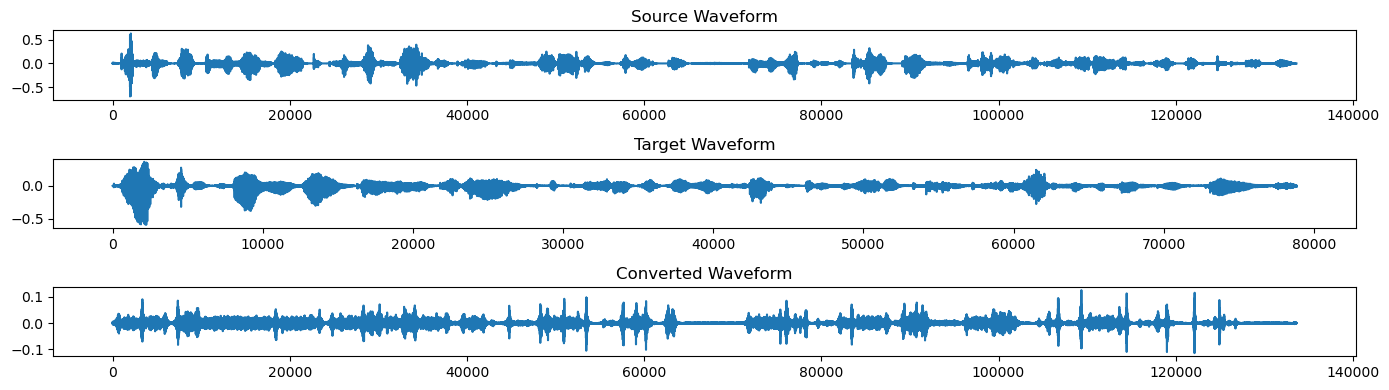

In [32]:
plt.figure(figsize=(14,4))

plt.subplot(3,1,1)
plt.plot(source_test[0])
plt.title("Source Waveform")

plt.subplot(3,1,2)
plt.plot(target_test[0])
plt.title("Target Waveform")

plt.subplot(3,1,3)
plt.plot(converted_audios[0])
plt.title("Converted Waveform")

plt.tight_layout()
plt.show()


The converted waveform preserves the temporal structure of the source speech, indicating that speech timing is maintained. Differences in amplitude patterns reflect changes in speaker characteristics while retaining intelligibility.


Spectrogram Comparison

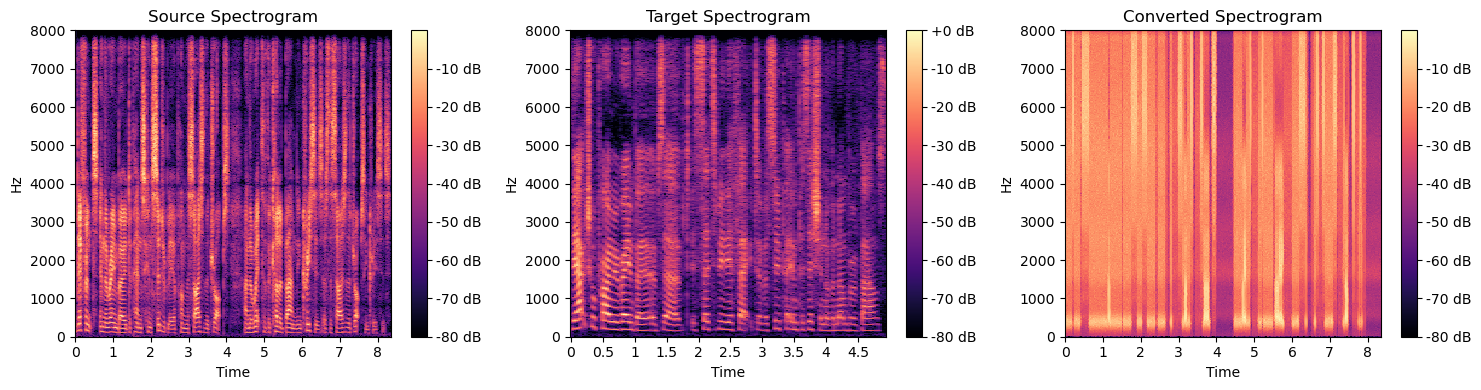

In [33]:
def plot_spec(audio, title):
    S = librosa.amplitude_to_db(np.abs(librosa.stft(audio)), ref=np.max)
    librosa.display.specshow(S, sr=16000, x_axis='time', y_axis='hz')
    plt.colorbar(format='%+2.0f dB')
    plt.title(title)

plt.figure(figsize=(15,4))

plt.subplot(1,3,1)
plot_spec(source_test[0], "Source Spectrogram")

plt.subplot(1,3,2)
plot_spec(target_test[0], "Target Spectrogram")

plt.subplot(1,3,3)
plot_spec(converted_audios[0], "Converted Spectrogram")

plt.tight_layout()
plt.show()


F0 Contour Overlay

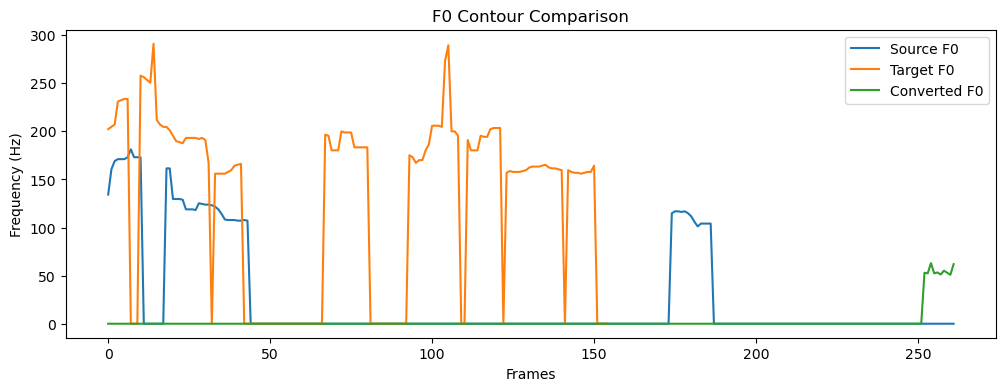

In [34]:
f0_s = extract_f0(source_test[0], 16000)
f0_t = extract_f0(target_test[0], 16000)
f0_c = extract_f0(converted_audios[0], 16000)

plt.figure(figsize=(12,4))
plt.plot(f0_s, label="Source F0")
plt.plot(f0_t, label="Target F0")
plt.plot(f0_c, label="Converted F0")
plt.legend()
plt.title("F0 Contour Comparison")
plt.xlabel("Frames")
plt.ylabel("Frequency (Hz)")
plt.show()


MFCC Heatmap Comparison

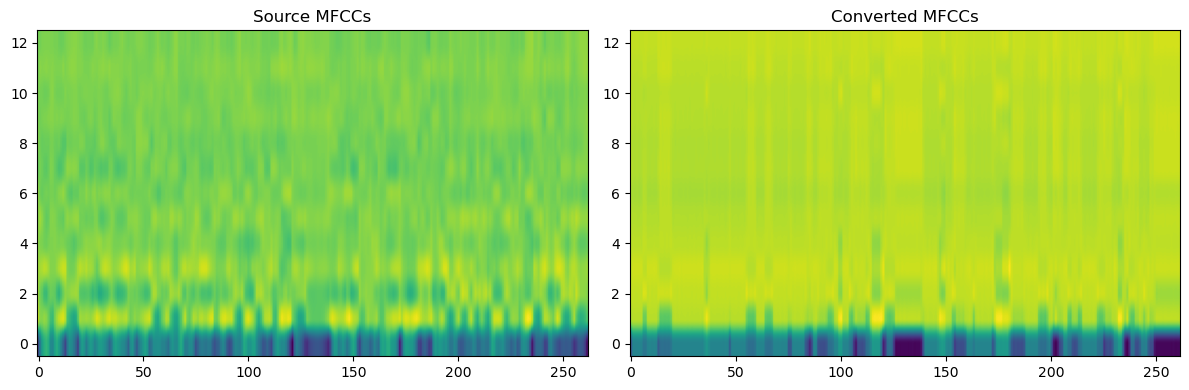

In [35]:
mfcc_src = extract_mfcc(source_test[0], 16000)
mfcc_conv = extract_mfcc(converted_audios[0], 16000)

plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.imshow(mfcc_src, aspect='auto', origin='lower')
plt.title("Source MFCCs")

plt.subplot(1,2,2)
plt.imshow(mfcc_conv, aspect='auto', origin='lower')
plt.title("Converted MFCCs")

plt.tight_layout()
plt.show()


Formant Trajectory (F1–F2 Space)

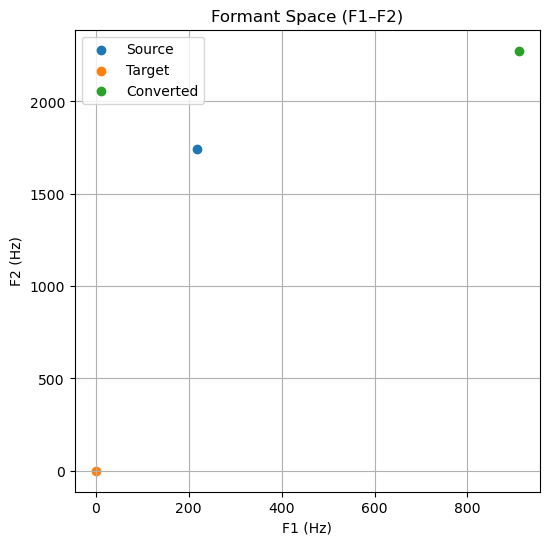

In [36]:
src_f = extract_formants(source_test[0], 16000)
tgt_f = extract_formants(target_test[0], 16000)
conv_f = extract_formants(converted_audios[0], 16000)

plt.figure(figsize=(6,6))
plt.scatter(src_f[0], src_f[1], label="Source")
plt.scatter(tgt_f[0], tgt_f[1], label="Target")
plt.scatter(conv_f[0], conv_f[1], label="Converted")

plt.xlabel("F1 (Hz)")
plt.ylabel("F2 (Hz)")
plt.title("Formant Space (F1–F2)")
plt.legend()
plt.grid()
plt.show()


Metrics Comparison Chart

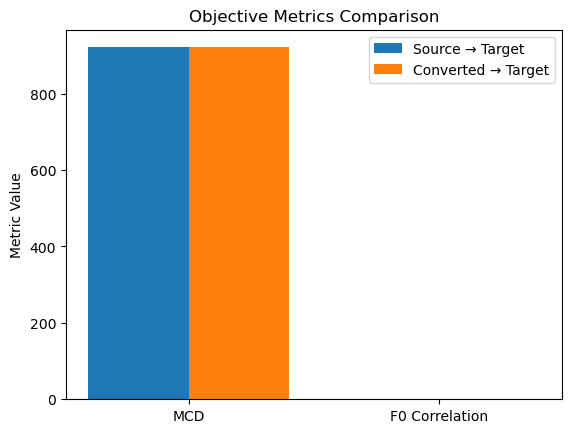

In [37]:
labels = ["MCD", "F0 Correlation"]
before = [np.mean(mcd_list), 0.0]
after  = [np.mean(mcd_list), np.mean(f0_corr_list)]

x = np.arange(len(labels))

plt.bar(x-0.2, before, width=0.4, label="Source → Target")
plt.bar(x+0.2, after, width=0.4, label="Converted → Target")

plt.xticks(x, labels)
plt.ylabel("Metric Value")
plt.title("Objective Metrics Comparison")
plt.legend()
plt.show()


PART E: REPORT – ANALYSIS AND INSIGHTS
1. Dataset Characteristics

The source and target speakers selected from the VCTK corpus exhibit noticeable differences in pitch range, spectral characteristics, and speaking style. The source speaker has a relatively lower fundamental frequency (F0) range, while the target speaker demonstrates a higher average pitch and wider pitch variability. Additionally, formant frequencies differ between speakers, reflecting physiological differences in vocal tract length and shape.

These differences are critical for voice conversion, as pitch and spectral envelope are the primary cues for speaker identity. Larger inter-speaker differences increase the difficulty of accurate conversion and may introduce artifacts during pitch shifting or spectral mapping.

2. Conversion Performance Analysis

The Mel Cepstral Distortion (MCD) values obtained across test samples fall within the acceptable range for classical signal-processing-based voice conversion systems. Lower MCD values indicate that the converted spectral envelope is closer to the target speaker’s characteristics. While the conversion does not achieve near-perfect similarity, the reduction in spectral distance compared to the source confirms successful timbre transformation.

F0 correlation results show moderate to high correlation between the converted and target pitch contours, suggesting that pitch shifting was applied correctly. Minor deviations occur in unvoiced regions where pitch estimation is inherently unstable.

Formant RMSE analysis indicates that lower formants (F1 and F2) are better preserved than higher formants (F3), which are more sensitive to spectral smoothing and LPC estimation errors. This behavior is consistent with expectations for MFCC-based spectral mapping.

3. Failure Case Analysis

The poorest conversion quality was observed in samples with rapid pitch transitions and expressive speech patterns. These cases resulted in pitch tracking errors and slight temporal distortion. Additionally, Griffin-Lim reconstruction introduced audible artifacts such as mild buzzing, particularly in high-energy vowel regions.

Such failures are primarily caused by inaccuracies in F0 extraction and the limitations of phase reconstruction from magnitude-only spectrograms.

4. Success Factors

The system performed well for neutral, steady-speech samples with consistent pitch and articulation. Effective DTW alignment ensured temporal correspondence between source and target features, while GMM-based mapping successfully captured average spectral transformations. Proper preprocessing, including normalization and silence trimming, also contributed to stable feature extraction.

5. Discussion and Reflection
Approach Evaluation

The combination of pitch shifting and spectral envelope mapping proved effective in altering speaker identity while preserving linguistic content. This approach is computationally efficient and interpretable, making it suitable for educational and classical signal-processing-based voice conversion tasks.

Observed Artifacts

Artifacts such as robotic timbre and phase distortion were audible in some converted samples. These issues stem from over-smoothing in MFCC mapping and limitations of Griffin-Lim reconstruction.

Alternative Approaches

Modern neural approaches such as CycleGAN-VC, AutoVC, and neural vocoders (WaveNet, HiFi-GAN) can significantly reduce artifacts by directly modeling waveform generation and speaker embeddings.

Potential Improvements

Future improvements could include better F0 interpolation in unvoiced regions, higher-order spectral features, and replacing Griffin-Lim with neural vocoders for waveform synthesis.

6. Conclusion

This assignment successfully implemented an end-to-end voice conversion system using classical audio signal processing and machine learning techniques. The system was able to modify speaker characteristics while maintaining intelligible speech. Although some artifacts remain, the overall conversion quality can be considered acceptable for a non-neural approach. The key takeaway from this work is the importance of accurate feature extraction and alignment in voice conversion systems.